In [ ]:
# make sure internet is available
# open kaggle.com and login

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

## Load data

In [3]:
# Create data object
df = pd.read_csv("car_sales_data.csv")
df.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


## Preprocessing

In [4]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [5]:
# Check null values
df.isna().sum()

Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
dtype: int64

In [6]:
# Check duplicate values
df.duplicated().sum()

np.int64(12)

In [7]:
# see duplicate values
df[df.duplicated(keep=False)]

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
2183,Ford,Mondeo,1.4,Diesel,1987,224569,883
5136,VW,Polo,1.2,Petrol,2003,10000,8024
5426,VW,Polo,1.2,Petrol,2003,10000,8024
5997,Toyota,Yaris,1.0,Petrol,1996,13500,5087
6033,VW,Passat,1.8,Diesel,1996,13500,9394
8881,BMW,Z4,2.4,Petrol,1999,12000,13410
9862,Ford,Mondeo,1.4,Diesel,1987,224569,883
11785,VW,Polo,1.0,Petrol,2000,11500,5950
14745,BMW,Z4,2.4,Petrol,1999,12000,13410
18313,VW,Polo,1.2,Petrol,2021,1000,27901


In [8]:
# Drop duplicate values
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
# Check duplicate values again
df[df.duplicated()]

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price


In [10]:
# check summary stat
df.describe()

,Engine size,Year of manufacture,Mileage,Price
count,49988.000000,49988.000000,49988.000000,49988.000000
mean,1.773140,2004.209630,112515.561215,13829.112387
std,0.734149,9.646056,71624.341062,16417.812203
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54375.250000,3059.750000
50%,1.600000,2004.000000,101011.500000,7971.000000
75%,2.000000,2012.000000,158617.250000,19028.500000
max,5.000000,2022.000000,453537.000000,168081.000000


## EDA

In [11]:
# select numerical columns
numerical_df = df.select_dtypes(include=['int64','float64'])
numerical_df.columns

Index(['Engine size', 'Year of manufacture', 'Mileage', 'Price'], dtype='object')

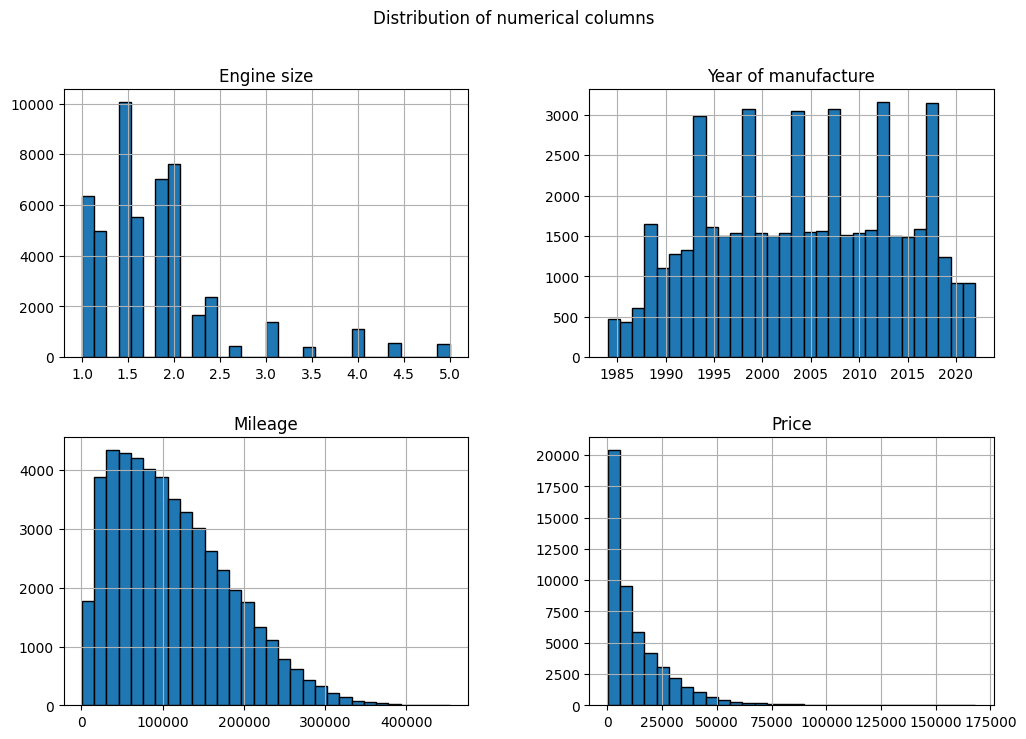

In [12]:
# Histograms
numerical_df.hist(figsize=(12,8),bins=30,edgecolor='black')
plt.suptitle("Distribution of numerical columns")
plt.show()

In [13]:
# checking outliers
outliers_dict = {}
for col in numerical_df.columns:
    Q1 = numerical_df[col].quantile(0.25)
    Q3 = numerical_df[col].quantile(0.75)
    IQR = Q3 - Q1

    # lower bound and upper bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # find outliers
    outliers = numerical_df[(numerical_df[col]< lower_bound) | (numerical_df[col] > upper_bound)]
    outliers_dict[col] = outliers

# print outliers
for col, outliers in outliers_dict.items():
    print(f"\nOutliers in '{col}':")
    print(outliers)


Outliers in 'Engine size':
       Engine size  Year of manufacture  Mileage   Price
1              4.0                 2016    57850   49704
26             3.5                 2005   151556   19747
41             4.0                 2017    22759   97758
99             4.4                 1987   226046    2956
101            4.4                 2008   109941   31711
...            ...                  ...      ...     ...
49938          4.0                 2015    47256   74105
49941          4.0                 2006   104899   18426
49966          3.0                 2006   106873   14336
49976          4.0                 1994   211856    5106
49995          5.0                 2018    28664  113006

[3951 rows x 4 columns]

Outliers in 'Year of manufacture':
Empty DataFrame
Columns: [Engine size, Year of manufacture, Mileage, Price]
Index: []

Outliers in 'Mileage':
       Engine size  Year of manufacture  Mileage  Price
85             1.0                 1993   333629    478
369  

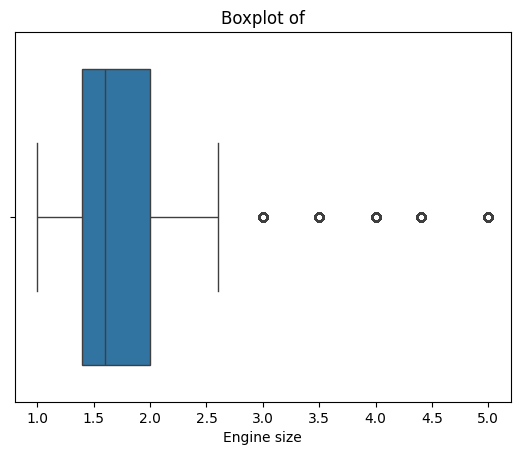

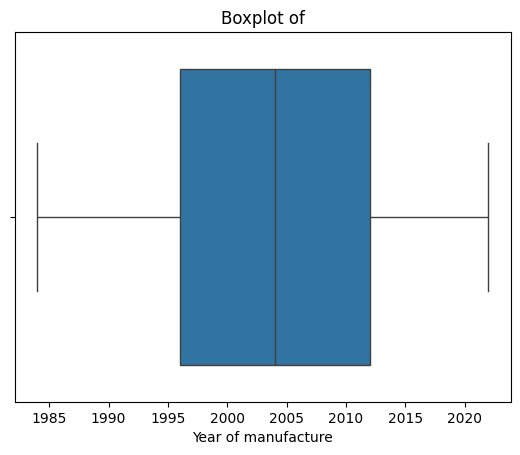

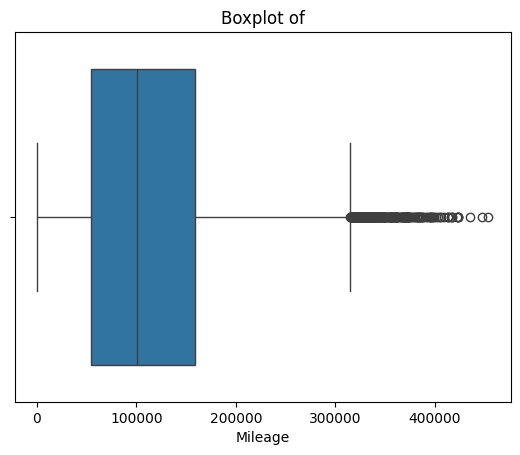

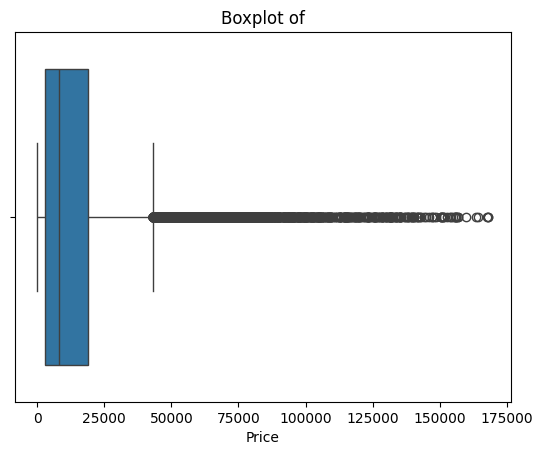

In [14]:
# Boxplot
for col in numerical_df.columns:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of")
    plt.show()

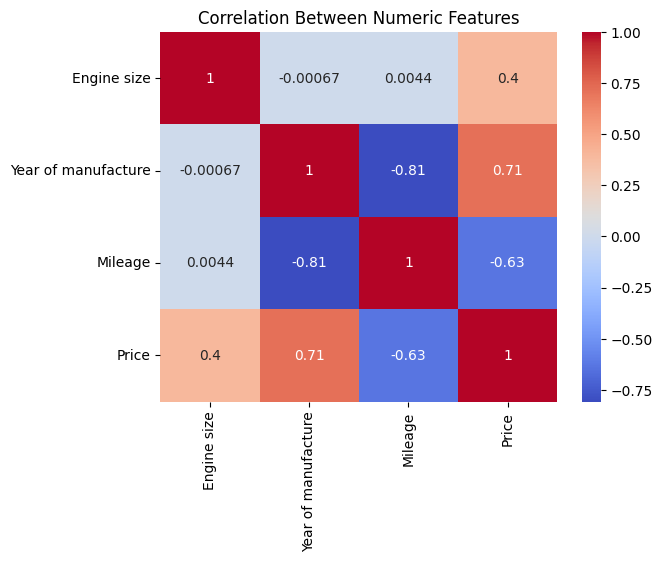

In [15]:
# Correlation heatmap
corr = numerical_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Numeric Features")
plt.show()

In [16]:
# categorical overview
for col in ["Manufacturer", "Model", "Fuel type"]:
    print(f"\nTop {col}s:")
    print(df[col].value_counts().head(5))


Top Manufacturers:
Manufacturer
Ford       14956
VW         14906
Toyota     12553
BMW         4964
Porsche     2609
Name: count, dtype: int64

Top Models:
Model
Mondeo    5057
Golf      5049
Polo      4988
Focus     4975
Fiesta    4924
Name: count, dtype: int64

Top Fuel types:
Fuel type
Petrol    25480
Diesel    13264
Hybrid    11244
Name: count, dtype: int64


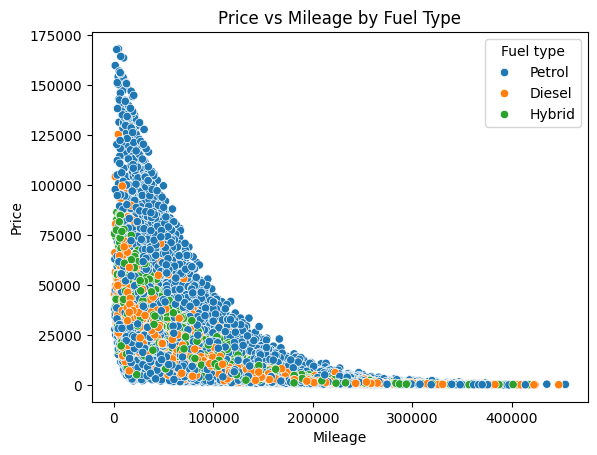

In [17]:
# Price vs Mileage
sns.scatterplot(data=df, x="Mileage", y="Price", hue="Fuel type")
plt.title("Price vs Mileage by Fuel Type")
plt.show()

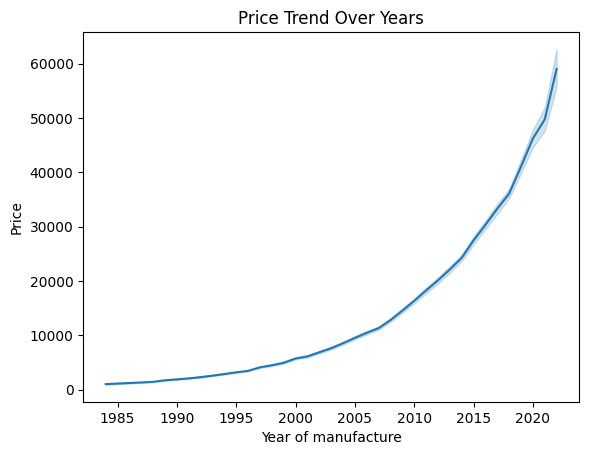

In [18]:
# Price over Years
sns.lineplot(data=df, x="Year of manufacture", y="Price")
plt.title("Price Trend Over Years")
plt.show()

## Preprocessing

In [19]:
# Feature Selection
X = df.drop("Price", axis=1)
y = df["Price"]
print(f"X:\n{X.head()}")
print(f"y:\n{y.head()}")

X:
  Manufacturer       Model  Engine size Fuel type  Year of manufacture  \
0         Ford      Fiesta          1.0    Petrol                 2002   
1      Porsche  718 Cayman          4.0    Petrol                 2016   
2         Ford      Mondeo          1.6    Diesel                 2014   
3       Toyota        RAV4          1.8    Hybrid                 1988   
4           VW        Polo          1.0    Petrol                 2006   

   Mileage  
0   127300  
1    57850  
2    39190  
3   210814  
4   127869  
y:
0     3074
1    49704
2    24072
3     1705
4     4101
Name: Price, dtype: int64


In [20]:
# One-hot encode categorical columns
encoded_df = pd.get_dummies(df, columns=['Fuel type'])

print(encoded_df)


      Manufacturer       Model  Engine size  Year of manufacture  Mileage  \
0             Ford      Fiesta          1.0                 2002   127300   
1          Porsche  718 Cayman          4.0                 2016    57850   
2             Ford      Mondeo          1.6                 2014    39190   
3           Toyota        RAV4          1.8                 1988   210814   
4               VW        Polo          1.0                 2006   127869   
...            ...         ...          ...                  ...      ...   
49995          BMW          M5          5.0                 2018    28664   
49996       Toyota       Prius          1.8                 2003   105120   
49997         Ford      Mondeo          1.6                 2022     4030   
49998         Ford       Focus          1.0                 2016    26468   
49999           VW        Golf          1.4                 2012   109300   

        Price  Fuel type_Diesel  Fuel type_Hybrid  Fuel type_Petrol  
0    

In [21]:
encoder = LabelEncoder()
label_df = df
label_df['label_Fuel_type'] = encoder.fit_transform(df['Fuel type'])
print(label_df[['Fuel type','label_Fuel_type']])

      Fuel type  label_Fuel_type
0        Petrol                2
1        Petrol                2
2        Diesel                0
3        Hybrid                1
4        Petrol                2
...         ...              ...
49995    Petrol                2
49996    Hybrid                1
49997    Diesel                0
49998    Diesel                0
49999    Diesel                0

[49988 rows x 2 columns]


In [22]:
# StandardScaler
scaler = StandardScaler()
scalar_df = df
scalar_df['scaled_Mileage'] = scaler.fit_transform(df[['Mileage']])

print(scalar_df[['Mileage','scaled_Mileage']])


       Mileage  scaled_Mileage
0       127300        0.206418
1        57850       -0.763234
2        39190       -1.023762
3       210814        1.372430
4       127869        0.214363
...        ...             ...
49995    28664       -1.170725
49996   105120       -0.103256
49997     4030       -1.514662
49998    26468       -1.201385
49999   109300       -0.044895

[49988 rows x 2 columns]


In [23]:
# Minmax Scalar
scaler = MinMaxScaler(feature_range=(10,20))
minmax_df = df
minmax_df['scaled_Mileage'] = scaler.fit_transform(df[['Mileage']])

print(minmax_df[['Mileage','scaled_Mileage']])

       Mileage  scaled_Mileage
0       127300       12.796821
1        57850       11.263394
2        39190       10.851389
3       210814       14.640776
4       127869       12.809385
...        ...             ...
49995    28664       10.618979
49996   105120       12.307096
49997     4030       10.075071
49998    26468       10.570492
49999   109300       12.399389

[49988 rows x 2 columns]


In [24]:
categorical = ["Manufacturer", "Model", "Fuel type"]
numerical = ["Engine size", "Year of manufacture", "Mileage"]

In [25]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

In [26]:
# Define models
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "KNN": KNeighborsRegressor()
}

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("reg", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    results.append((name, round(r2, 3), round(rmse, 2)))

In [29]:
# Display Results
results_df = pd.DataFrame(results, columns=["Model", "R² Score", "RMSE"])
print(results_df.sort_values(by="R² Score", ascending=False))

              Model  R² Score         RMSE
6           XGBoost     0.999    305178.31
4      RandomForest     0.999    401741.85
7               KNN     0.998    446997.38
3      DecisionTree     0.996    993201.97
5  GradientBoosting     0.990   2727772.83
2             Lasso     0.715  77285008.53
0            Linear     0.715  77286184.48
1             Ridge     0.715  77286227.06
